# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 18 апреля 2018, 06:00 <br\>
**Штраф за опоздание:** -3 балла после 06:00 18 апреля, -6 баллов после 06:00 25 апреля, -9 баллов после 06:00 2 мая

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

%matplotlib inline
%load_ext pycodestyle_magic

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [3]:
USER_NAME = u"Храмов".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print ("Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
))

Имплементируйте обучение логистической регрессии с L2 регуляризацией с помощью метода Mini Batch Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь
$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log(\sigma(y^{(i)} g(x^{(i)}))\right] + \frac{1}{C}\sum_{j=1}^{m}|w_j| $$
могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Реализация модели

## Вывод правила обновления весов (1 балл)

Выведите правило обновления весов на каждом шаге алгоритма. Иными словами, посчитайте производную (градиент) функции потерь с регуляризацией. Формулы надо оформлять в формате LaTeX.

$$L(w_0,w_1,\dots) = -\frac{1}{N}\sum_i \log(\sigma(y^{(i)} g(x^{(i)}))) + \frac{1}{C}\sum_jw_j^2 $$
$$ \sigma(z) = \frac{1}{1+e^{-z}}, \quad  g(x) = w_0+(w,x)$$

$$ \frac{\partial L}{\partial w_0}   = -\frac{1}{N} \sum_i y^{(i)} \sigma(-y^{(i)} g(x^{(i)})) + \frac{2w_0}{C}$$

$$ \frac{\partial L}{\partial w_k}   = -\frac{1}{N} \sum_i y^{(i)} x_k^{(i)}\sigma(-y^{(i)} g(x^{(i)})) + \frac{2w_k}{C}$$


## Имплементация (5 баллов)

In [3]:


from sklearn.base import BaseEstimator, ClassifierMixin


class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """

    def __init__(self, C=1, alpha=0.1, max_epoch=10, batch_count=10):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """

        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_count = batch_count

    def fit(self, X, y):
        '''
        Обучение модели
        '''
        N = y.size
        X_ = np.concatenate((np.ones(N).reshape(-1, 1), X), axis=1)
        self.weights = np.random.rand(X_.shape[1])
        self.loss = np.ones(self.max_epoch)
        classes = np.unique(y)
        y_ = np.ones(N)
        y_[y == classes[0]] = -1
        ind = np.arange(N)
        for ep in range(self.max_epoch):
            alpha = self.alpha / (ep + 1)
            np.random.shuffle(ind)

            x_i = np.array_split(X_[ind], self.batch_count)
            y_i = np.array_split(y_[ind], self.batch_count)

            for i in range(self.batch_count):
                grad_k = (-np.sum(
                    (self.sigma(-y_i[i] * np.sum(self.weights * x_i[i], axis=1))
                     * y_i[i]).reshape(y_i[i].size, -1) * x_i[i], axis=0) /
                          self.batch_count + 2 * self.weights / self.C)

                grad_0 = -np.sum(
                    (self.sigma(-y_i[i] * np.sum(self.weights * x_i[i], axis=1))
                     * y_i[i]), axis=0) / self.batch_count + 2 * self.weights[0] / self.C
                
                
                self.weights[1:] = self.weights[1:] - alpha * grad_k[1:]
                self.weights[0] = self.weights[0] - alpha * grad_0

            self.loss[ep] = (- np.sum(
                np.log(self.sigma(y_ *
                                  np.sum(self.weights * X_, axis=1)))) /
                             y_.size + self.weights.dot(self.weights) / self.C)

    @staticmethod
    def sigma(x):
        return 1 / (1 + np.exp(-x))

    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        y_hat = 1 * (self.predict_proba(X)[0] > 0.5)

        return y_hat

    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        X_ = np.concatenate((np.ones(X.shape[0]).reshape(-1, 1), X), axis=1)
        p_plus = self.sigma(X_.dot(self.weights))
        y_hat_proba = (p_plus, 1 - p_plus)

        return y_hat_proba


## Проверка на синтетических данных (1 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

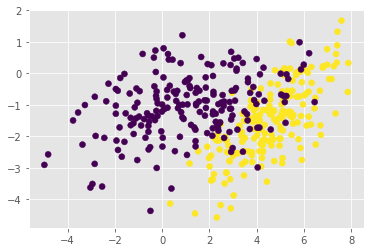

In [3]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:,0], X[:,1], c=y, )



In [4]:
clf = MySGDClassifier(max_epoch=100, C=1000, alpha=1)
clf.fit(X, y)

In [5]:
pr = clf.predict(X)
print ( accuracy_score(y_pred=pr, y_true=y))

0.895


w_0 = -6.251137368555206
w_1 = 1.32652878096701
w_2 = -1.5139748538689242


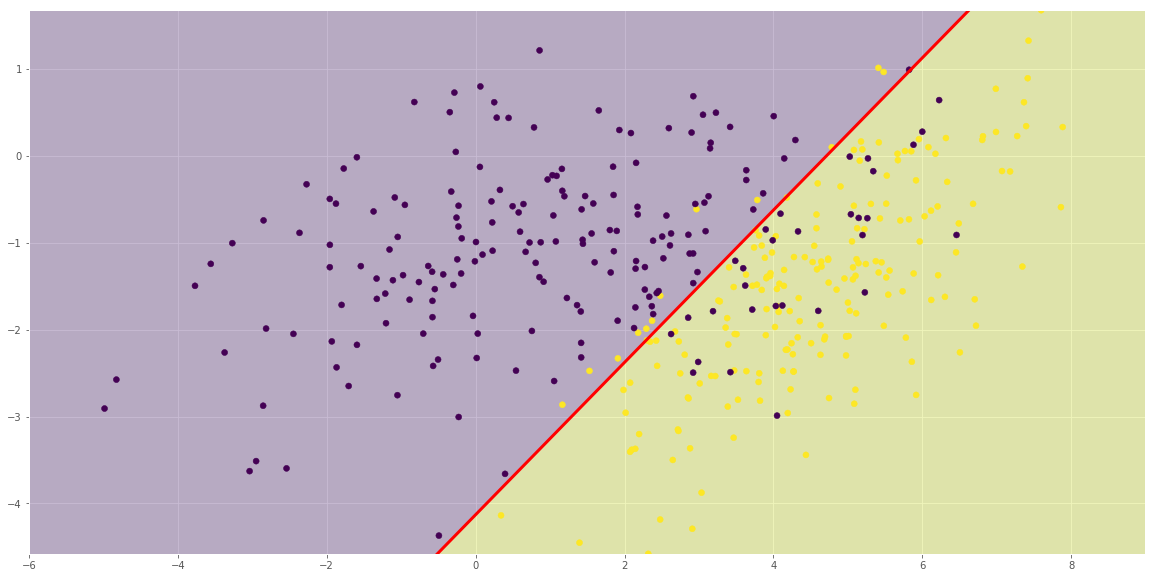

In [6]:
plt.figure(figsize=(20,10))
x_min, x_max = -6, 9
y_min, y_max = -5, 3
h=0.01
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
xr = xx.ravel()
yr = yy.ravel()
xy = np.vstack((xr, yr)).T
y_ = clf.predict(xy)
y_ = y_.reshape(xx.shape)
plt.contourf(xx, yy, y_, alpha=0.29)

weights = clf.weights

x = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
plt.plot(x, -(weights[0] + weights[1] * x) / weights[2], 'r', linewidth=3.0)
plt.scatter(X[:, 0], X[:, 1],c=y)
plt.ylim(X[:,1].min(), X[:,1].max())

for (i, w) in enumerate(weights):
    print('w_{} = {}'.format(i, w))

## Анализ сходимости (2 балла)

Для следующих заданий используйте датасет ниже

In [71]:
from sklearn.datasets import make_classification

In [72]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

Text(0.5,0,'epoch')

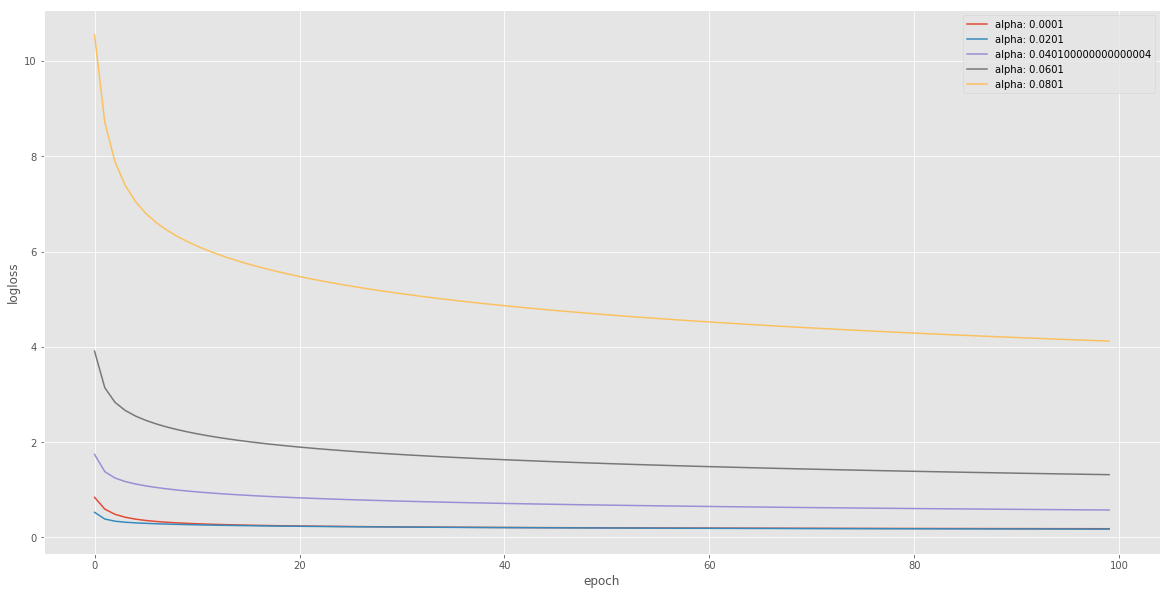

In [73]:
## Your Code Here
plt.figure(figsize=(20,10))

loss = []
i = 0
for alph in np.arange(0.0001,0.1,0.02):
    clf = MySGDClassifier(max_epoch=100, C=1000, alpha=alph)
    clf.fit(X,y)
    loss.insert(len(loss), clf.loss)
    plt.plot(range(100),loss[i],label='alpha: {}'.format(alph))
    i += 1
plt.legend()
plt.ylabel('logloss')
plt.xlabel('epoch')



## Эффект регуляризации (2 балла)

Изобразите значения коэффициентов модели для каждого С из `np.logspace(3, -3, 10)` (желательно на одном и том же графике)

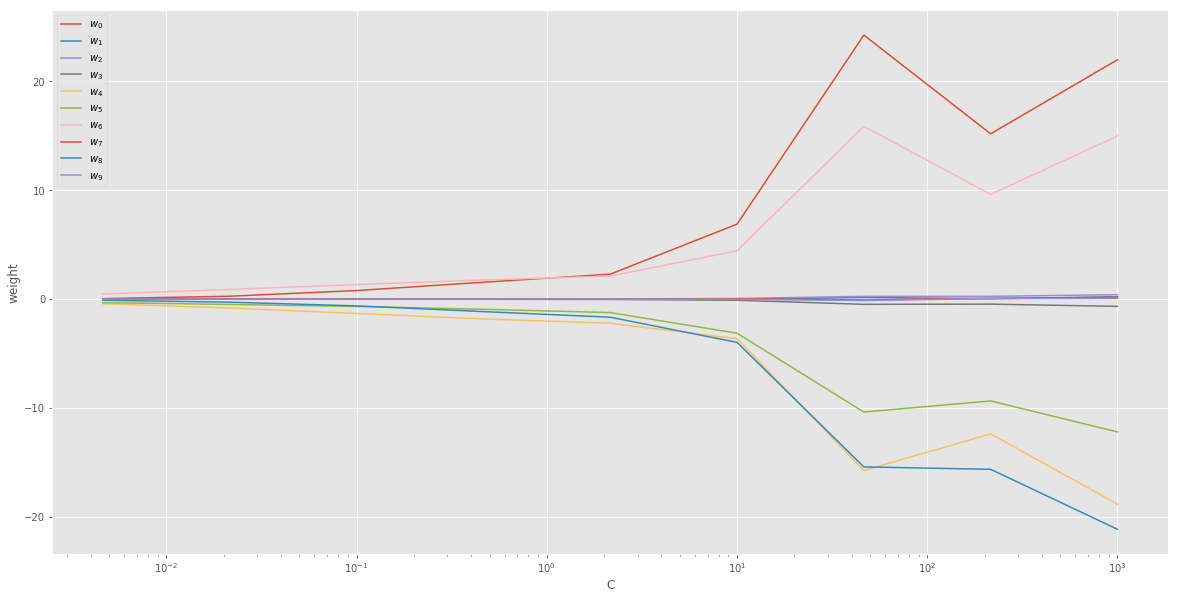

In [74]:
## Your Code Here
plt.figure(figsize=(20,10))
w = np.zeros((10, 11 ))
for i, c in enumerate(np.logspace(3, -3, 10)):
    clf = MySGDClassifier(max_epoch=100, C=c, alpha=0.1)
    clf.fit(X, y)
    w[i, :] = clf.weights
    
for i in range(10):   
    plt.plot(np.logspace(3, -3, 10), w[:, i], label='$w_{%d}$' % i)
    plt.xscale('log')
plt.xlabel('C')
plt.ylabel('weight')
plt.legend()

# Боевое применение

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если все данные не будут помещаться вам с оперативную память, то можете использовать один из 4х файлов для обучения

In [4]:
# Загрузка данных целиком
# df_list = []
# for chunk in range(1,5):
#     filepath = './trainingData_tabular_chunk%d.csv' % chunk
#     df_list.append(pd.read_csv(filepath, sep=','))
# df_data = pd.concat(df_list)

# Загрузка одной части данных
filepath = './trainingData_tabular_chunk1.csv'
df_data = pd.read_csv(filepath, sep=',')

In [5]:
df_data.shape

(500000, 45)

In [6]:
X = np.float64(df_data[df_data.columns[1:]].values)

In [7]:
X.shape

(500000, 44)

In [8]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [8]:
df_data.head().T

gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [9]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.504702

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы


In [10]:
## Youd Code Here
print("player unique card count" , np.unique(df_data.opponent_hero_card_id).size)
print("opponent unique card count" ,np.unique(df_data.player_hero_card_id).size)

player unique card count 9
opponent unique card count 9


In [11]:
df_data_oneHot = pd.get_dummies(df_data, columns=['opponent_hero_card_id', 'player_hero_card_id'])
df_data_oneHot.head().T

gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1
opponent_deck_count,11,19,22,17,12


## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Создайте Pipeline из `StandartScaller` и вашей модели
* Обучите модель (подбирать гиперпараметры можно без фанатизма)

In [12]:
## Youd Code Her
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

X_train = df_data_oneHot.iloc[:, 1:].values
y_train = df_data_oneHot.iloc[:, 0].values

ss = StandardScaler()
model = MySGDClassifier(C=500, alpha=4,max_epoch=10)

s_model = Pipeline([('scaler', ss), ('model', model)])
s_model.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', MySGDClassifier(C=500, alpha=4, batch_count=10, max_epoch=10))])

In [13]:
X_train.shape

(500000, 59)

## Применение модели (2 балла)
#### Задание
* Загрузите тестовые данные
* Подготовте их к подаче на вход в алгоритм
* Примените модель оцените качество с помощью меры ROC-AUC


In [14]:
## Youd Code Here
df_list = []

for i in range(5, 8):
    filepath = './testData_tabular_chunk%d.csv' % i
    df_list.append(pd.read_csv(filepath, sep=','))
df_data_test = pd.concat(df_list)



df_data_test.columns = df_data_test.columns.str.replace('.', '_')
df_data_test = df_data_test.set_index('gamestate_id')

In [15]:
df_data_test = pd.get_dummies(df_data_test, columns=['opponent_hero_card_id', 'player_hero_card_id'])

X_test = np.float64(df_data_test.iloc[:, 1:].values)

In [16]:
y_pred = s_model.predict_proba(X_test)[0]

In [17]:
y_test = pd.read_table('deprecated_testLabels.txt', names=['decision'])

print("ROC " ,roc_auc_score(y_test, y_pred))



ROC  0.6401918709416899


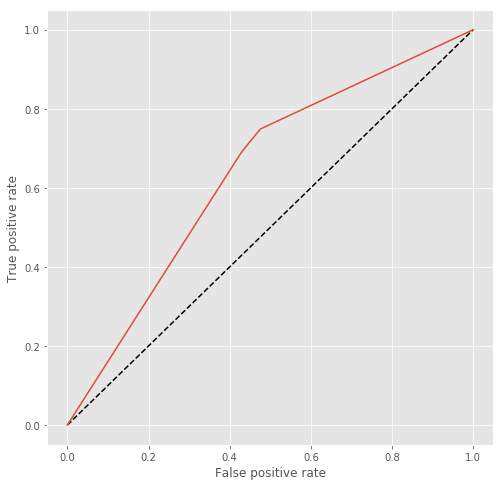

In [18]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.plot(fpr, tpr)
plt.show()